Script de medición y carga de las colecciones en cluster MongoDB
TFM Daniel Herranz Segundo

In [102]:
import pandas as pd
import numpy as np
import os
import json
import random
import pymongo
from pymongo import MongoClient
import time
from pprint import pprint
from pymongo import InsertOne, DeleteMany, ReplaceOne, UpdateOne
import matplotlib.pyplot as plt

In [83]:
#Variables de los ficheros de datos salida
CurrentAccountCollection_file_out = '../MockData/MongoDB/CurrentAccountCollection/CurrentAccountCollection.json'
PositionKeepingCollection_file_out = '../MockData/MongoDB/PositionKeepingCollection/PositionKeepingCollection.json'
CustomerProfileCollection_file_out = '../MockData/MongoDB/CustomerProfileCollection/CustomerProfileCollection.json'

CurrentAccountCollection_sample_out = '../MockData/MongoDB/CurrentAccountCollection/CurrentAccountCollection_sample.json'
PositionKeepingCollection_sample_out = '../MockData/MongoDB/PositionKeepingCollection/PositionKeepingCollection_sample.json'
CustomerProfileCollection_sample_out = '../MockData/MongoDB/CustomerProfileCollection/CustomerProfileCollection_sample.json'

CurrentAccountCollection_sample_10K_out = '../MockData/MongoDB/CurrentAccountCollection/CurrentAccountCollection_10K_sample.json'
PositionKeepingCollection_sample_10K_out = '../MockData/MongoDB/PositionKeepingCollection/PositionKeepingCollection_10K_sample.json'
CustomerProfileCollection_sample_10K_out = '../MockData/MongoDB/CustomerProfileCollection/CustomerProfileCollection_10K_sample.json'

CurrentAccountCollection_sample_100K_out = '../MockData/MongoDB/CurrentAccountCollection/CurrentAccountCollection_100K_sample.json'
PositionKeepingCollection_sample_100K_out = '../MockData/MongoDB/PositionKeepingCollection/PositionKeepingCollection_100K_sample.json'
CustomerProfileCollection_sample_100K_out = '../MockData/MongoDB/CustomerProfileCollection/CustomerProfileCollection_100K_sample.json'

CurrentAccountCollection_sample_500K_out = '../MockData/MongoDB/CurrentAccountCollection/CurrentAccountCollection_500K_sample.json'
PositionKeepingCollection_sample_500K_out = '../MockData/MongoDB/PositionKeepingCollection/PositionKeepingCollection_500K_sample.json'
CustomerProfileCollection_sample_500K_out = '../MockData/MongoDB/CustomerProfileCollection/CustomerProfileCollection_500K_sample.json'

In [92]:
#Los resultados de medidas de tiempo en carga por dominios se almacenan en estos objetos.
#Se itera durante 100 iteraciones para sacar medias
CustomerProfileDomainSchema_ds = []
PositionKeepingDomainSchema_ds = []
CurrentAccountDomainSchema_ds = []

#repeticiones
repeats = 1000


In [93]:
#Conexion unica a colecciones
connection = MongoClient('localhost', 27017, w=3) #Conexion con WriteConcern a 3 (primario y dos nodos consolidados)
print(connection.list_database_names())

#Creamos una base de datos para el trabajo llamada TFM
tfm_mongo_db = connection["tfm_mongo_database"]

['admin', 'config', 'local']


## Creación de las colecciones por cada dominio

In [94]:
CustomerProfileCollection = tfm_mongo_db["CustomerProfileCollection"]

## Carga de los documentos por cada dominio

### Test de carga CustomerProfileCollection

In [95]:
Address_ETL_times = []

In [96]:
#Carga de la información de dataframes por entidades

CustomerProfileCollection_df = pd.read_json(CustomerProfileCollection_sample_out) #Carga Sample
#CustomerProfileCollection_df = pd.read_csv(CustomerProfileCollection_file_out) # Carga final

In [97]:
CustomerProfileCollection_df.sample(1)

,PartyId,PartyNumber,PartyType,Name,FullLegalName,LegalStructure,BeneficialOwnership,AccountRole,EmailAddress,Phone,Address
581,7128,7128,sol,Angelica,Cali Eichmann,Prof.,4,UK.OBIE.Secundary,umorar@example.org,284.189.2399,"[{'AddressType': 'Port', 'AddressLine': '784 B..."


In [98]:
len(CustomerProfileCollection_df)

1000

In [99]:
#Borramos los valores actuales de la colección
connection["tfm_mongo_database"].CustomerProfileCollection.drop()
print('Borrada colleción CustomerProfileCollection')

Borrada colleción CustomerProfileCollection


In [100]:
#Cargas Masiva con Many
for i in range(0,repeats):
    time_inicial = time.time()
    CustomerProfileCollection.insert_many(CustomerProfileCollection_df.to_dict('records'))
    time_final = time.time()
    data_time_CustomerProfile = time_final - time_inicial
    CustomerProfileDomainSchema_ds.append(data_time_CustomerProfile)

In [101]:
#---- Resultados inserccion coleccion con metodo insertMany
print("DOCUMENTS:" , len(CustomerProfileCollection_df) * repeats, 'seg')
print("MAX:" , max(CustomerProfileDomainSchema_ds), 'seg')
print("MIN:" , min(CustomerProfileDomainSchema_ds), 'seg')
print("AVG:" , np.average(CustomerProfileDomainSchema_ds), 'seg')

DOCUMENTS: 1000000 seg
MAX: 0.31179070472717285 seg
MIN: 0.037491559982299805 seg
AVG: 0.04382792329788208 seg


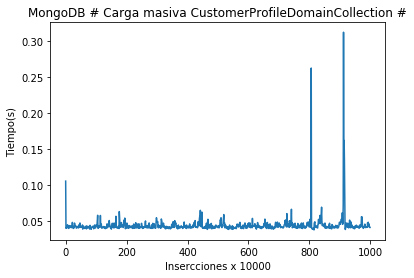

In [103]:
gfg = pd.Series(CustomerProfileDomainSchema_ds)  
gfg.plot()
plt.title("MongoDB # Carga masiva CustomerProfileDomainCollection #")
plt.xlabel("Insercciones x 10000")
plt.ylabel("Tiempo(s)")
plt.show()